# Chess Board Position Recogniser

## Setup

### Libraries

In [1]:
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from PIL import Image

import chess

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import wandb

In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [4]:
DATA_DIR = pathlib.Path.cwd().parent / "data" / "deepconvchess-dataset" / "dataset"

NUM_CLASSES = len(['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K'])

## Create TensorFlow Dataset

### Crop Each Image To 64 Partitions

In [5]:
# Dataset
X = []
y = []

for file in DATA_DIR.iterdir():
    if file.is_file() and file.name.endswith(".jpeg"):
        print("Processing %s" % file.name)

        fen = file.name.split(".")[0]
        fen = fen.replace("_", "/")
        board = chess.Board(fen)
        
        # Open image of Chess board
        img = Image.open(DATA_DIR / file.name)
        IMG_WIDTH, IMG_HEIGHT = img.size

        # Crop each image into 64 sections, one for each tile on the board
        for i in range(8):
            for j in range(8):
                crop_x = j * IMG_WIDTH // 8
                crop_y = i * IMG_HEIGHT // 8
                img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

                piece = board.piece_at(((7 - i) * 8) + j)
                if piece is not None:
                    piece = piece.symbol()
                else:
                    piece = '_'

                X.append(np.array(img_crop))
                y.append(piece)

Processing 1N2r3_2q1ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 b - - 0 21.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 w - - 0 22.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2PQ1P2_1P4P1_P5BP_3RR1K1 b - - 1 22.jpeg
Processing 1r1q1rk1_1ppb1pbp_p1np1np1_8_2PNP3_2N1BP2_PP1QB1PP_R4RK1 w - - 6 12.jpeg
Processing 1r1Q2k1_5ppp_2q1p3_1p6_2p2P2_P3P3_1Q4PP_1R4K1 b - - 0 27.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 w - - 2 17.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 b - - 0 17.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 b - - 1 16.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 w - - 0 16.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 b - - 0 15.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_2N3P1_PP1Q1PBP_R3R1K1 w - - 3 15.jpeg
Processing 1r2r3_1bqnppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 w - - 1 18.jpeg
Processing 1r2r3_1bqnp

In [6]:
len(X)

30208

In [7]:
X = np.array(X)
y = np.array(y)

### Display Example Cropped Board

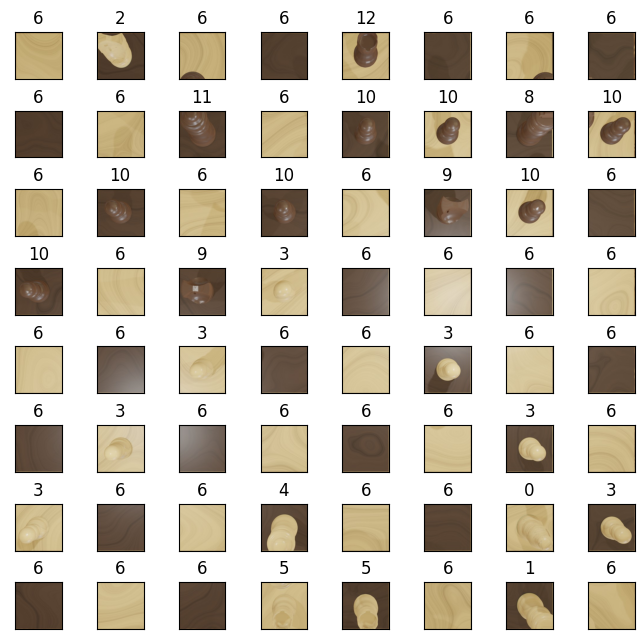

In [34]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

### Encode Labels

In [9]:
# Define the labels
labels = ['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']

label_encoder = LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform(y)

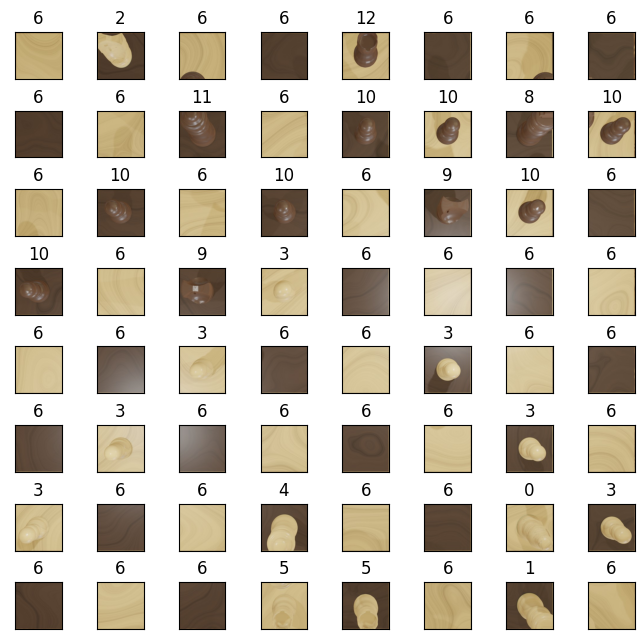

In [35]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

### Test and Train Split

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the train and test split
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (24166, 160, 160, 3)
y_train shape: (24166,)
X_test shape: (6042, 160, 160, 3)
y_test shape: (6042,)


## Weights and Bias

### Callback to Log Statistics

In [12]:
class EpochLogCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        train_loss = logs.get('loss')
        
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        wandb.log(
            {
                'accuracy': train_acc, 
                'loss': train_loss,
                'val_accuracy': val_acc,
                'val_loss': val_loss
            }
        )

## Models

### ResNet

#### ResNet-50

In [13]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "renset50",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
resnet_model = ResNet50(input_shape=(160, 160, 3), include_top=False)
resnet_model.trainable = False

model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: billy-wba8. Use `wandb login --relogin` to force relogin


Epoch 1/5
756/756 [==============================] - 32s 35ms/step - loss: 0.0546 - accuracy: 0.9882 - val_loss: 0.0174 - val_accuracy: 0.9972
Epoch 2/5
756/756 [==============================] - 25s 32ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0068 - val_accuracy: 0.9992
Epoch 3/5
756/756 [==============================] - 24s 32ms/step - loss: 1.6254e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 4/5
756/756 [==============================] - 25s 33ms/step - loss: 6.0741e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9993
Epoch 5/5
756/756 [==============================] - 25s 33ms/step - loss: 3.9376e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9993


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,▁▇███
val_loss,█▃▁▁▁
accuracy,1.0
loss,4e-05
val_accuracy,0.99934
val_loss,0.00167


### MobileNet

#### MobileNetV1

In [18]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv1",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNet(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/5
756/756 [==============================] - 12s 14ms/step - loss: 0.2396 - accuracy: 0.9371 - val_loss: 0.1014 - val_accuracy: 0.9753
Epoch 2/5
756/756 [==============================] - 10s 14ms/step - loss: 0.0546 - accuracy: 0.9885 - val_loss: 0.0605 - val_accuracy: 0.9866
Epoch 3/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0285 - accuracy: 0.9947 - val_loss: 0.0467 - val_accuracy: 0.9894
Epoch 4/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0160 - accuracy: 0.9977 - val_loss: 0.0339 - val_accuracy: 0.9909
Epoch 5/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0098 - accuracy: 0.9990 - val_loss: 0.0280 - val_accuracy: 0.9927


accuracy,▁▇███
loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▃▂▁
accuracy,0.99897
loss,0.00978
val_accuracy,0.99272
val_loss,0.02796


#### MobileNetV2

In [22]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv2",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Epoch 1/5
756/756 [==============================] - 16s 19ms/step - loss: 0.1180 - accuracy: 0.9718 - val_loss: 0.0334 - val_accuracy: 0.9930
Epoch 2/5
756/756 [==============================] - 14s 18ms/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 0.0238 - val_accuracy: 0.9949
Epoch 3/5
756/756 [==============================] - 16s 21ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.0194 - val_accuracy: 0.9962
Epoch 4/5
756/756 [==============================] - 15s 20ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0194 - val_accuracy: 0.9962
Epoch 5/5
756/756 [==============================] - 14s 19ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0133 - val_accuracy: 0.9967


accuracy,▁▇███
loss,█▂▁▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▃▁
accuracy,0.99992
loss,0.00153
val_accuracy,0.99669
val_loss,0.01326


#### MobileNetV3

##### MobileNetV3-Small

In [27]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv3-small",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV3Small(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/5
756/756 [==============================] - 16s 18ms/step - loss: 0.0887 - accuracy: 0.9786 - val_loss: 0.0096 - val_accuracy: 0.9978
Epoch 2/5
756/756 [==============================] - 12s 16ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0065 - val_accuracy: 0.9980
Epoch 3/5
756/756 [==============================] - 12s 16ms/step - loss: 6.7664e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 4/5
756/756 [==============================] - 13s 17ms/step - loss: 3.5847e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9985
Epoch 5/5
756/756 [==============================] - 13s 17ms/step - loss: 2.1601e-04 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9987


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,▁▂▇▇█
val_loss,█▃▂▁▁
accuracy,1.0
loss,0.00022
val_accuracy,0.99868
val_loss,0.0051


##### MobileNetV3-Large

In [28]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv3-large",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV3Large(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

12683000/12683000 [==============================] - 1s 0us/step
Epoch 1/5
756/756 [==============================] - 19s 22ms/step - loss: 0.0592 - accuracy: 0.9856 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 2/5
756/756 [==============================] - 15s 20ms/step - loss: 7.2701e-04 - accuracy: 0.9999 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 3/5
756/756 [==============================] - 15s 20ms/step - loss: 2.8551e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 4/5
756/756 [==============================] - 16s 21ms/step - loss: 1.8025e-04 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 5/5
756/756 [==============================] - 17s 22ms/step - loss: 8.9902e-05 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9992


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,██▁▁█
val_loss,▄▃▂█▁
accuracy,1.0
loss,9e-05
val_accuracy,0.99917
val_loss,0.00336


### Evaluate Model

Text(0.5, 1.0, '3')

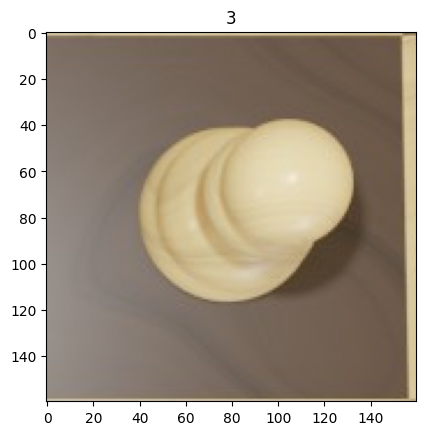

In [14]:
plt.imshow(X_test[0])
plt.title(y_test[0])

#### Predictions

In [15]:
for i in range(0, 8):
    image = np.expand_dims(X_test[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    print("True Label: %s, Predicted Label: %s\n" % (label_encoder.inverse_transform([y_test[i]]), prediction))

1/1 [==============================] - 1s 733ms/step
True Label: ['P'], Predicted Label: ['P']

1/1 [==============================] - 0s 23ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['p'], Predicted Label: ['p']

1/1 [==============================] - 0s 19ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 21ms/step
True Label: ['P'], Predicted Label: ['P']



## Evaluation

In [16]:
fen = "rnbqkbnr_pppppppp_8_8_8_8_PPPPPPPP_RNBQKBNR w KQkq - 0 1.jpg".split(".")[0]
fen = fen.replace("_", "/")
board = chess.Board(fen)

img = Image.open(DATA_DIR / "validation" / "rnbqkbnr_pppppppp_8_8_8_8_PPPPPPPP_RNBQKBNR w KQkq - 0 1.jpg")
IMG_WIDTH, IMG_HEIGHT = img.size

X_val = []
y_val = []

# Crop each image into 64 sections, one for each tile on the board
for i in range(8):
    for j in range(8):
        crop_x = j * IMG_WIDTH // 8
        crop_y = i * IMG_HEIGHT // 8
        img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

        piece = board.piece_at(((7 - i) * 8) + j)
        if piece is not None:
            piece = piece.symbol()
        else:
            piece = '_'

        X_val.append(np.array(img_crop))
        y_val.append(piece)

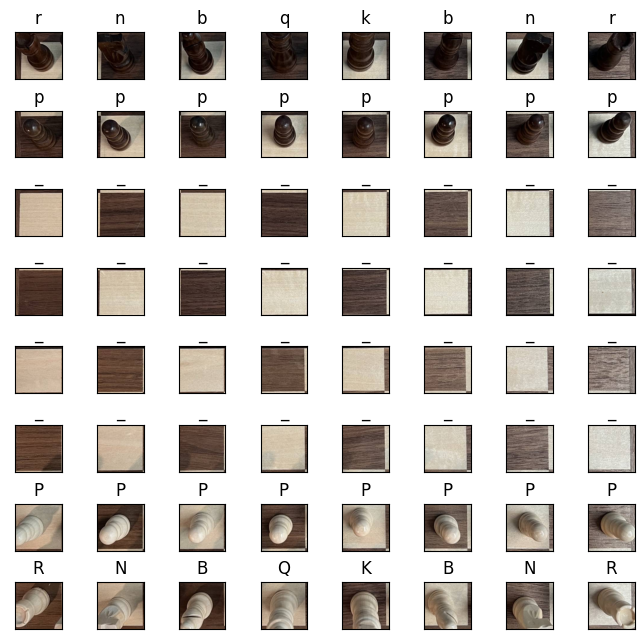

In [32]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_val[i])
    plt.title(y_val[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [18]:
predicted_y = []
for i in range(0, 64):
    image = np.expand_dims(X_val[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    predicted_y.append(prediction[0])

1/1 [==============================] - 0s 20ms/step


In [52]:
for i in range(0, len(predicted_y)):
    if predicted_y[i] != '_':
        piece = chess.Piece.from_symbol(predicted_y[i])
        square = chess.SQUARES[63 - i]
        board.set_piece_at(square, piece)

predicted_fen = board.fen()
predicted_fen

'rnkKrbBr/bbpppppp/8/8/8/8/BBBBpBBB/BBBKKBBB w - - 0 1'

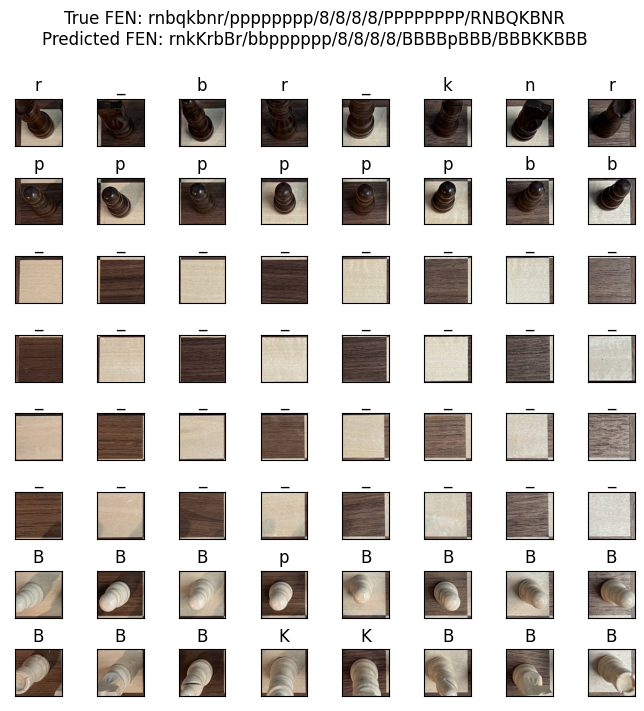

In [53]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_val[i])
    plt.title(predicted_y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

fig.suptitle("True FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR\nPredicted FEN: %s" % predicted_fen.split(" ")[0])
fig.savefig('predicted_board', dpi=300, bbox_inches='tight')

In [60]:
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = label_encoder.transform(y_val)

In [63]:
loss, accuracy = model.evaluate(X_val, y_val)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

2/2 [==============================] - 0s 34ms/step - loss: 2.0335 - accuracy: 0.7031
Test loss: 2.0335044860839844
Test accuracy: 0.703125
